# Best model coefficients by mortality group
- Standardised coefficient plots count/cmass
- Coefficient table for count/cmass

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [18]:
# Load libraries
import numpy as np
import pandas as pd
import sys
import os
import pickle
import glob
import seaborn as sns
from classes import boundaries as bd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning

from classes import boundaries as bd

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 


#--- Notebook run settings
run = 'command line' # 'manual' 'command line'
#run = 'manual'


#--- Arguments
if run == 'command line':
    # Read command line arguments
    arguments = os.environ['NB_ARGS']
    date_exp_str, alpha, standardise_covars = arguments.split(',')
    
    alpha              = float(alpha)   
    standardise_covars = bool(standardise_covars)

elif run == 'manual':
    standardise_covars = False        # Standardise the covariates before running model selection
    date_exp_str = '230413_Management'
    alpha = 0.01


In [19]:
#---------------#
#  Import data  #
#---------------#
date_exp_str_original = date_exp_str

levels             = ['Site', 'Species']
path_levels        = ['site_reg_results/','spe_reg_results/']
mtf_type           = ['count', 'cmass']
climate_data_plot  = {'CRUclim':'$CRU_{clim}$',
                      'CRUNCEPv7':'$CRU_{obs}$',
                      'CHELSA30s':'$CHELSA_{30s}$',
                      'WorldClim30s':'$WorldClim_{30s}$',
                      'WorldClim10m':'$WorldClim_{10m}$',}

mortality_groups = ['M_All','M_Fire','M_NoFire','M_Other']

if standardise_covars:
    sorter       = ['DBH_mean','MAT','PFT','Managed']
else:
    sorter       = ['Intercept','DBH_mean','MAT','PFT', 'Managed']
    
with open(date_exp_str+'_Table4_df.pkl', 'rb') as f:
    table4_df = pickle.load(f)
table4_df = table4_df.reset_index()    

display(table4_df) 

Level Mortality                           model    r2        RMSE        \
                                                     count cmass count cmass   
0     Site     M_All  MTF ~ MAT + DBH_mean + Managed  0.36  0.42  23.4  49.2   
1     Site    M_Fire                  MTF ~ DBH_mean  0.54  0.47  21.0  54.9   
2     Site  M_NoFire                       MTF ~ MAT  0.32  0.37  23.0  45.0   
3     Site   M_Other                       MTF ~ MAT  0.36  0.43  24.4  47.8   
4  Species     M_All  MTF ~ MAT + DBH_mean + Managed  0.61   0.6  25.9  43.9   
5  Species    M_Fire                  MTF ~ DBH_mean   0.7  0.65  38.4  67.8   
6  Species  M_NoFire      MTF ~ MAT + PFT + DBH_mean  0.54  0.54  12.4  18.8   
7  Species   M_Other      MTF ~ MAT + PFT + DBH_mean  0.58  0.58  12.5  19.0   

     ID        N_obs  
  count cmass         
0     0     0   64.0  
1     0     0   17.0  
2    12    15   47.0  
3    14    15   37.0  
4     3     1  107.0  
5     1     0   37.0  
6     1     1   70.0  
7     0     0   61.0

In [20]:
# --- Specifify experiments for import
spe_all_data_f = [date_exp_str+'',               'CRUNCEPv7', alpha]
spe_fire_f     = [date_exp_str+'_FireOnly',      'CRUNCEPv7', alpha]
spe_no_fire_f  = [date_exp_str+'_NoFire',        'CRUNCEPv7', alpha]
spe_other      = [date_exp_str+'_NoInsectsFire', 'CRUNCEPv7', alpha]

species_import = [spe_all_data_f,spe_fire_f,spe_no_fire_f,spe_other] 
sort_dict      = {i:j for i,j  in zip(sorter,np.arange(len(sorter)))}

modN_spe_stand_list = [(6,0),(6,0),(2,1),(0,0)]

#--- Initialise
data_mtf_type = np.empty((len(levels),len(mtf_type),),dtype='object')
data          = np.empty((len(levels),len(mortality_groups)),dtype='object')



if standardise_covars:
    st=1
    levels = levels[1:]
else:
    st=0
    levels = levels

for l,lev in enumerate(levels): 

    if standardise_covars:
        l = 1
        
    print(lev,l)


    
    table4_df_ss = table4_df[table4_df.Level == lev].copy()
    
    arr_coeff = np.empty((len(mortality_groups),len(mtf_type)),dtype='object')
    
    for i,keys in enumerate(species_import):
        
        # import data
        date_exp_str, climate_data, alpha = keys
        import_str = path_levels[l]+date_exp_str+'_S*_'+str(alpha)+'_'+climate_data+'.pkl'
        print(glob.glob(import_str))
        import_str = glob.glob(import_str)[0]
        
        with open(import_str, 'rb') as f:
            data[l,i] = pickle.load(f)
            #display(data[l,i])
            
        for t,tpe in enumerate(mtf_type):
            if (st == 1): # Standardised covars
                modN = modN_spe_stand_list[i][t]
                print(modN)
            else:        # Actual model coefficients
                modN = table4_df_ss.loc[(table4_df_ss.Mortality == mortality_groups[i]), 
                                        [('ID',tpe)]].values[0][0]
            df = pd.DataFrame()
            df['Mortality']    = np.nan
            
            if np.isnan(modN): # Management subset: Fire Mortality at site level
                df['Value']        = np.nan
                df['Std_error']    = np.nan
            else:
                df['Value']        = data[l,i][st,t,1][modN].params
                df['Std_error']    = data[l,i][st,t,1][modN].bse
            
            df.loc[df['Mortality'].isnull(), 'Mortality'] = mortality_groups[i]
            df['MTF_type']     = tpe
            df['Level']        = lev
            arr_coeff[i,t] = df

    for t in range(2):
        data_mtf_type[l,t]         = pd.concat(arr_coeff[:,t],axis=0)
        data_mtf_type[l,t]         = data_mtf_type[l,t].reset_index()
        data_mtf_type[l,t].columns = ['Coefficients','Mortality','Value','Std_error','MTF_type','Level' ]

Site 0
['site_reg_results/230413_Management_SITE_0.01_CRUNCEPv7.pkl']
['site_reg_results/230413_Management_FireOnly_SITE_0.01_CRUNCEPv7.pkl']
['site_reg_results/230413_Management_NoFire_SITE_0.01_CRUNCEPv7.pkl']
['site_reg_results/230413_Management_NoInsectsFire_SITE_0.01_CRUNCEPv7.pkl']
Species 1
['spe_reg_results/230413_Management_SPE_0.01_CRUNCEPv7.pkl']
['spe_reg_results/230413_Management_FireOnly_SPE_0.01_CRUNCEPv7.pkl']
['spe_reg_results/230413_Management_NoFire_SPE_0.01_CRUNCEPv7.pkl']
['spe_reg_results/230413_Management_NoInsectsFire_SPE_0.01_CRUNCEPv7.pkl']


In [21]:
# Get unstandardised coefficients in a table
if not standardise_covars:
    df = pd.DataFrame()
    for l,lev in enumerate(levels):
        
        # Initialise    
        df_coef_paper = pd.DataFrame()

        for t,data in enumerate(data_mtf_type[l]):
            ss = data[['Mortality', 'Coefficients', 'Value', 'Std_error','MTF_type']]
            ss = ss.round(2)
            ss['MTF_type'] = mtf_type[t]
            ss['Val_std'] =[str(i)+' ('+str(j)+')' for i,j in zip(ss.Value.to_list(),ss.Std_error.to_list())]
            ss_idx = ss.set_index(['Mortality', 'Coefficients','MTF_type'])
            ss_unstacked = ss_idx['Val_std'].unstack(level=[1,2])

            df_coef_paper = pd.concat([df_coef_paper,ss_unstacked],axis=1)

        df_coef_paper = df_coef_paper.sort_index(axis=1, level=[0, 1],ascending=False)
        df_coef_paper = df_coef_paper.replace('nan (nan)',np.nan)
        df_coef_paper.reset_index(inplace=True)
        df_coef_paper['Level'] = lev
        df = pd.concat([df,df_coef_paper])
    df.set_index(['Level', 'Mortality'],inplace=True)
    df = df[['Intercept','DBH_mean','MAT','PFT','Managed']]
    display(df)

    # Store for management influence comparison
    with open(date_exp_str_original+'_Table5_Management_covariate_coefficients.pkl','wb') as f:
            pickle.dump(df,f)

Coefficients         Intercept                  DBH_mean               \
MTF_type                 count        cmass        count        cmass   
Level   Mortality                                                       
Site    M_All      2.64 (0.22)  3.25 (0.23)  0.03 (0.01)  0.03 (0.01)   
        M_Fire     1.44 (0.37)  2.13 (0.41)  0.05 (0.01)  0.05 (0.01)   
        M_NoFire   3.25 (0.15)   3.9 (0.16)          NaN          NaN   
        M_Other     3.4 (0.16)  4.07 (0.17)          NaN          NaN   
Species M_All       2.4 (0.13)  2.71 (0.15)   0.04 (0.0)   0.04 (0.0)   
        M_Fire     1.51 (0.22)  1.83 (0.25)   0.05 (0.0)  0.05 (0.01)   
        M_NoFire   2.52 (0.16)  2.83 (0.18)  0.02 (0.01)  0.02 (0.01)   
        M_Other    2.54 (0.17)  2.87 (0.19)  0.02 (0.01)  0.02 (0.01)   

Coefficients                MAT                        PFT               \
MTF_type                  count         cmass        count        cmass   
Level   Mortality                                                         
Site    M_All      -0.09 (0.02)  -0.11 (0.02)          NaN          NaN   
        M_Fire              NaN           NaN          NaN          NaN   
        M_NoFire   -0.11 (0.02)  -0.13 (0.02)          NaN          NaN   
        M_Other    -0.12 (0.03)  -0.15 (0.03)          NaN          NaN   
Species M_All      -0.12 (0.02)  -0.13 (0.02)          NaN          NaN   
        M_Fire              NaN           NaN          NaN          NaN   
        M_NoFire   -0.13 (0.02)  -0.14 (0.02)  0.44 (0.14)  0.43 (0.15)   
        M_Other    -0.14 (0.02)  -0.15 (0.02)  0.52 (0.14)  0.52 (0.15)   

Coefficients            Managed                
MTF_type                  count         cmass  
Level   Mortality                              
Site    M_All      -0.69 (0.21)  -0.78 (0.22)  
        M_Fire              NaN           NaN  
        M_NoFire            NaN           NaN  
        M_Other             NaN           NaN  
Species M_All      -0.45 (0.13)  -0.49 (0.15)  
        M_Fire              NaN           NaN  
        M_NoFire            NaN           NaN  
        M_Other             NaN           NaN

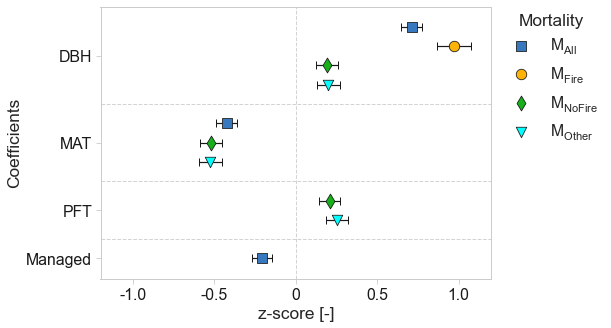

In [17]:
#--- Plot settings
marker_list = 'sodv'
marker_list = ['s','o','d','v']
coef_plot   = ['DBH','MAT','PFT','Managed']
xticks      = np.array(np.arange(-1,1.5,0.5),dtype='object')
xticks[2]   = int(0)

sns.set_context("paper", font_scale=1.8)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'

labels_new = ['$M_{All}$', '$M_{Fire}$', '$M_{NoFire}$', '$M_{Other}$']
if standardise_covars:
    
    st_data              = data_mtf_type[1][0] # species; standardised
    st_data.Coefficients = st_data.Coefficients.astype('category')
    st_data.Coefficients.cat.set_categories(sorter, inplace=True)
    st_data              = st_data.groupby(['Mortality', 'Coefficients']).first().reset_index().copy()
    st_data              = st_data[~st_data.Coefficients.isna()].copy()
    st_data              = st_data.sort_values(by=['Coefficients'], key=lambda x: x.map(sort_dict))
    st_data              = st_data.sort_values(by=['Coefficients','Mortality',]).reset_index(drop=True).copy()
    st_data['y_vals']    = np.nan
    
    base_y               = np.arange(0,len(st_data[st_data.Value.notnull()].index))
    y_vals = pd.Series(base_y[::-1], index=st_data[st_data.Value.notnull()].index)
    st_data.loc[st_data.Value.notnull(), 'y_vals'] = y_vals
    
    y_label_position = np.empty((len(sorter),))
    for i,var in enumerate(sorter):
        if i > 0:
            st_data.loc[st_data['Coefficients']==var, 'y_vals'] -= 1*i
            y_label_position[i] = st_data.loc[st_data['Coefficients']==var, 'y_vals'].mean()
        else:
            y_label_position[i] = st_data.loc[st_data['Coefficients']==var, 'y_vals'].mean()
    
    # Add space between mortality groups
    add_space = np.arange(0,len(sorter))
    
    fig, ax = plt.subplots(1,1, figsize=(7,5))

    for m,mort in enumerate(mortality_groups):
        mod = st_data[st_data['Mortality'] == mort]
        
        mod.Coefficients.cat.set_categories(sorter, inplace=True)

        Y = mod.y_vals.values

        #print(Y)
        ax.barh(Y, 
                mod['Value'].values, 
                xerr=mod['Std_error'], 
                color='none',
                edgecolor='none',
                capsize=4
               )

        ax.scatter(x=mod['Value'].values,
                   marker=marker_list[m], 
                   s=110, 
                   y=Y,
                   zorder=2,
                   edgecolor='k', label=mort
                  )

    #plt.grid()    
    ax.set_xlim(-1.2,1.2)


    ax.axvline(x=0, linestyle='--', color='lightgrey', linewidth=1)
    ax.axhline(y=5, linestyle='--', color='lightgrey', linewidth=1)
    ax.axhline(y=1, linestyle='--', color='lightgrey', linewidth=1)
    ax.axhline(y=-2, linestyle='--', color='lightgrey', linewidth=1)
    


    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticks(np.arange(-1,1.5,0.5),xticks)
        ax.set_yticks(y_label_position, coef_plot)
        ax.set_yticklabels(coef_plot,color='k')
        ax.set_xticklabels(xticks, color='k')
        handles, labels = ax.get_legend_handles_labels()



    ax.grid()
    plt.legend(handles,labels_new, bbox_to_anchor=(1,1.03),loc='upper left',title='Mortality',frameon=False)
    plt.xlabel('z-score [-]')
    plt.ylabel('Coefficients')
    plt.savefig('Figure6_species_mort_group_standardised_coef_plot.png',dpi=300,bbox_inches='tight')
    plt.show()
